# **스파크 colab에 환경 구현**

In [1]:
# jdk 툴 설치
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# apache spark download - 하둡 버전에 따라 spakr 와 하둡 변경 (밑에 tgz 파일 설치 및 pip install)
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
# 명령어로 spark - hadoop 파일 압축 풀기
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
# spark 설치
!pip install -q findspark

In [2]:
import os
# spark 환경변수 설정 - java(jdk) ,spark(spark) 2개다 설정해줘야함
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [3]:
#import spark 말고 findspark로 spark파일을 못찾는경우에 빠르게 설치 가능
import findspark
findspark.init()

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

# **RDD(Resilient Distributed Data)란?**

Resilient Distributed Dataset의 약어인 RDD는 직역하면 탄력적인 분산 데이터셋이다.

스파크(Spark)가 사용하는 핵심 데이터 모델로서, 다수의 서버에 걸쳐 분산 방식으로 저장된 요소들의 집합을 의미하며, 병렬 처리가 가능하고 장애가 발생할 경우 스스로 복구될 수 있는 내성을 가지고 있다.

즉, RDD란 스파크에서 정의한 분산 데이터 모델인데, 내부에는 단위 데이터를 포함하고 있고 저장할 때는 여러 서버에 나누어 저장되며, 처리할 때는 각 서버에 저장된 데이터를 동시에 병렬로 처리할 수 있는 모델이다.

이전 프로젝트 포스팅의 SparkContext를 초기화하고 textFile을 이용하여 파일을 로딩하게 되는데, 이 때 담긴 lines라는 객체가 바로 RDD이다.

텍스트 파일을 함수로 불러올 수도 있고 여러가지 데이터를 불러 올 때 RDD의 형태로 가져올 수 있다.

In [ ]:
# count-trips.py
from pyspark import SparkConf, SparkContext
import pandas as pd

# Spark 설정
# SparkConf를 이용해 Master/Local 설정을 하고, 앱 이름을 정해준다.
conf = SparkConf().setMaster("local").setAppName("uber-date-trips")
# conf라는 객체를 SparkContext를 초기화 하는 데 사용한다.
sc = SparkContext.getOrCreate(conf=conf)


# 데이터 파싱
lines = sc.textFile("fhvhv_tripdata_2020-03.csv")
# header = lines.first()
filtered_lines = lines.filter(lambda row:row != header) 

# 필요한 부분만 골라내서 세는 부분
# countByValue로 같은 날짜가 등장하는 부분을 센다.
dates = filtered_lines.map(lambda x: x.split(",")[2].split(" ")[0])
result = dates.countByValue()

# Spark코드가 아닌 일반적인 파이썬 코드
# CSV로 결과값 저장 
pd.Series(result, name="trips").to_csv("trips-date.csv")

# **RDD의 5가지 특징**

**1. 데이터 추상화**

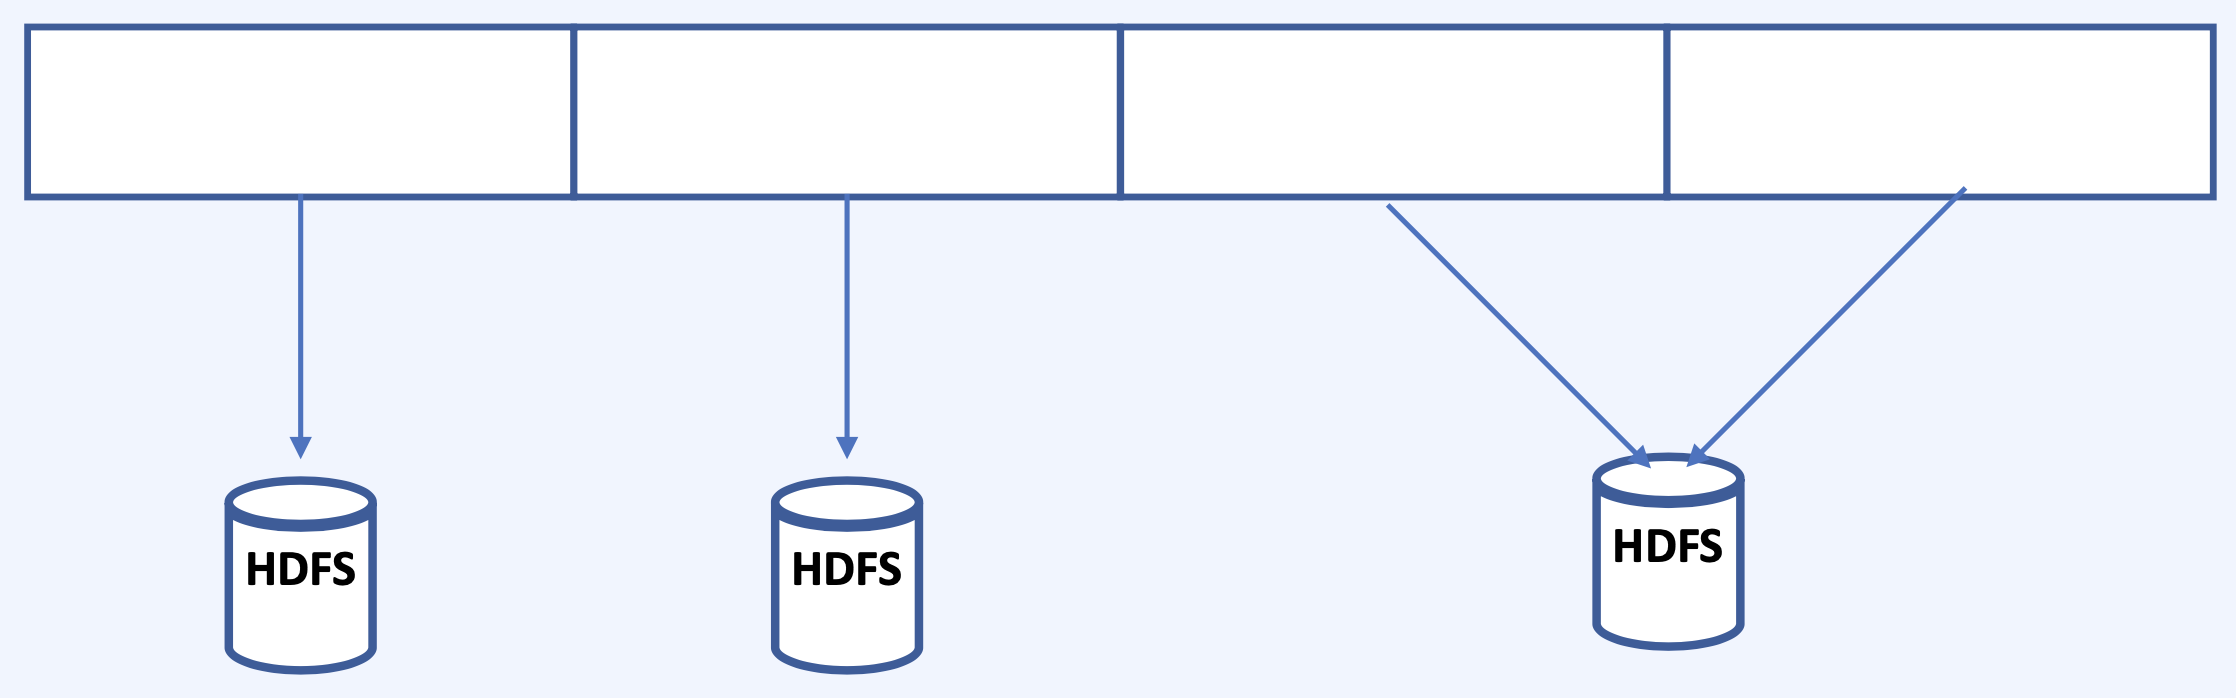

이터는 클러스터에 흩어져 있지만 하나의 파일인 것처럼 사용이 가능하다.

여러 군데의 데이터를 객체 하나에 담을 수 있다.

**2. 탄력적 & 불변성**

데이터는 탄력적이고 불변(Resilient & Immutable)하는 성질이 있다.

만약 데이터가 네트워크 장애나 하드웨어, 메모리 문제, 알수 없는 갖가지 이유로 연산 중 여러 노드 중 하나가 망가진다면, 데이터가 불변(immutable)하면 문제가 일어날 때 복원이 가능해진다.

RDD1이 변환을 거치면 RDD1이 변하는 것이 아니라, 새로운 RDD2가 만들어진다.
그렇기에 변환을 거칠 때 마다 연산의 기록이 남는다.

RDD의 변환 과정은 하나의 비순환 그래프(Acyclic Graph)로 그릴 수 있기 때문에 문제가 생길 경우 쉽게 전 RDD로 돌아갈 수 있다.

만약 Node 1이 연산 중 문제가 생긴다면 다시 복원 후 Node 2에서 연산하면 되기 때문에 탄력적인 성질을 가졌다고 볼 수 있다.

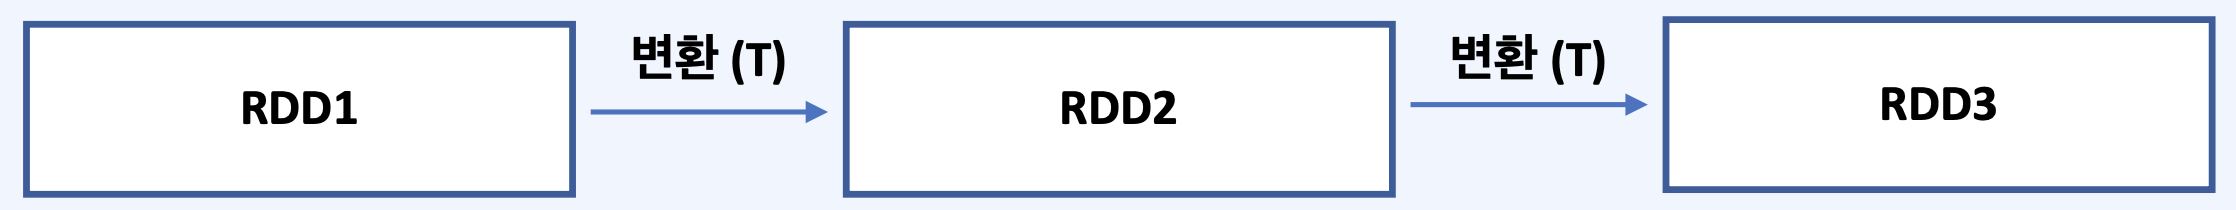

**3. 타입 세이프(Type-safe)**

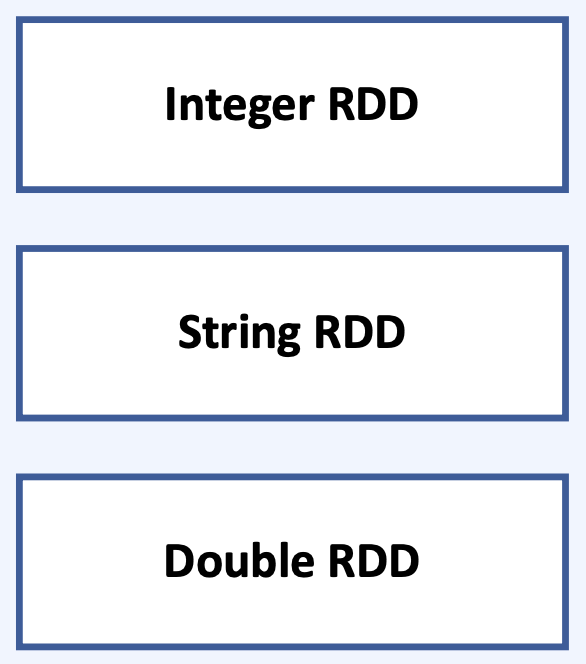

RDD는 컴파일 시 타입을 판별할 수 있어 문제를 일찍 발견할 수 있기 때문에 개발자 친화적이다.

**4. 정형 & 비정형 데이터**

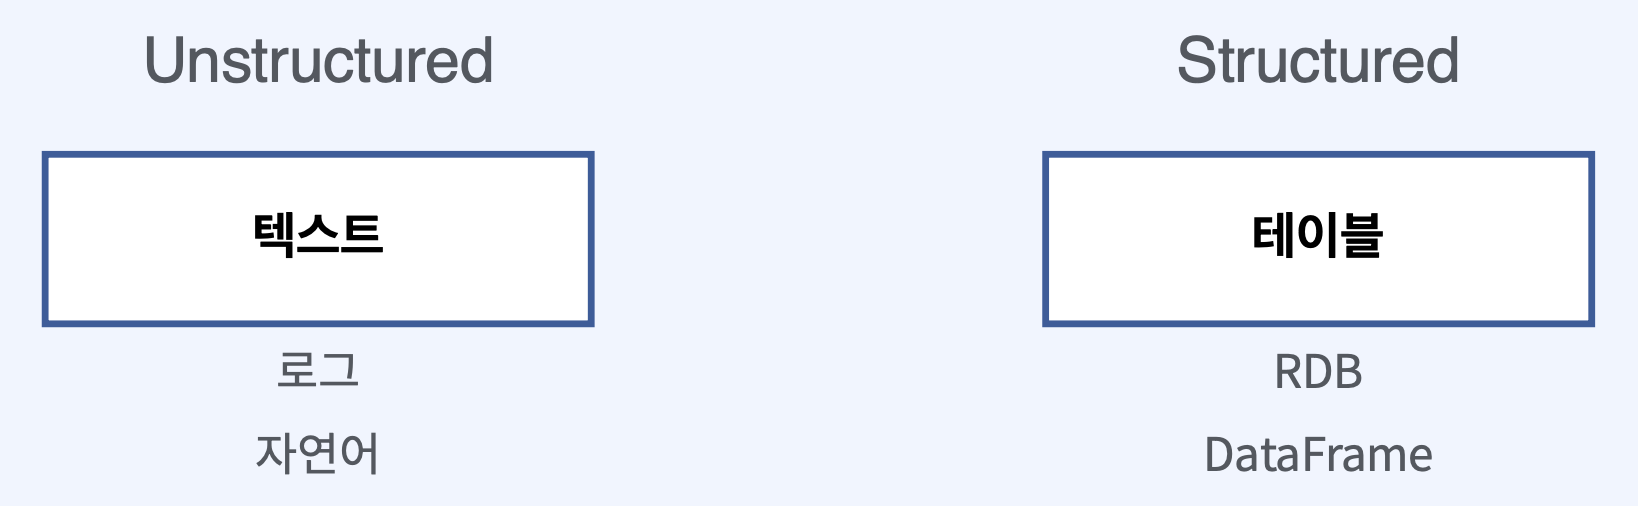

정형/비정형 데이터(Unstructured/Structured Data)를 모두 담을 수 있다.

**5. 게으르다.**

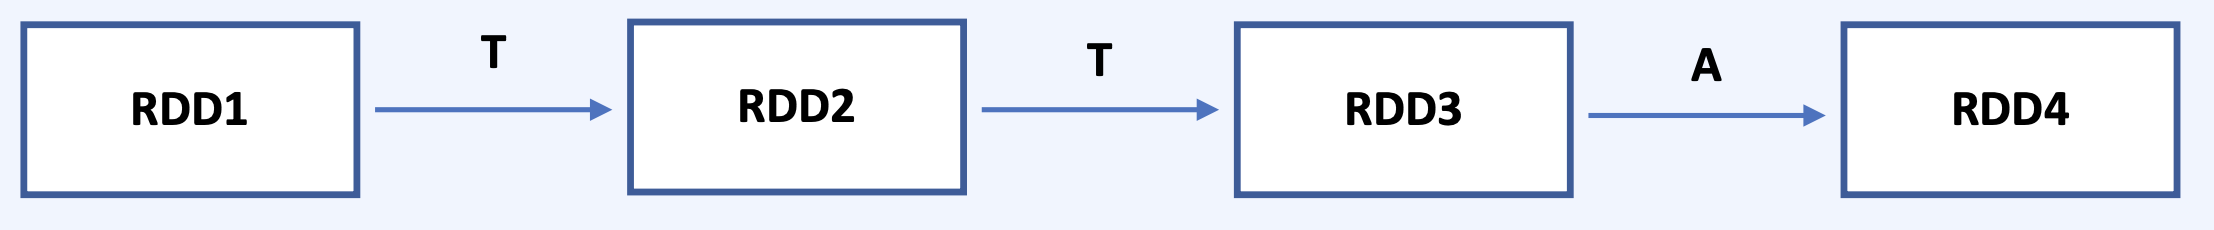

RDD는 연산이 필요할 때까지 연산을 하지 않는다.

액션(A, Action)을 할 때 까지 변환(T, Transformation)은 실행되지 않는다.

스파크 오퍼레이션 = 변환 + 액션

RDD3에서 RDD4로의 액션이 일어나기 전까지 RDD1 -> RDD2 -> RDD3까지의 변환을 실행하지 않는다. => 게으른 연산(Lazy Evaluation)

**RDD의 사용 이유**

유연하다.

짧은 코드로 할 수 있는 게 많다.

개발할 때 ‘무엇’보다는 ‘어떻게’에 대해 더 생각하게 한다.

게으른 연산 덕분에 데이터가 어떻게 변환될 지 생각하게 된다.

데이터가 지나갈 길을 닦는 느낌이다.

# **사용 방법**

In [13]:
from pyspark import SparkConf, SparkContext
import pandas as pd

SparkConf: 사용자가 재정의해서 쓸 수 있는 설정 옵션에 대한 키와 값을 가진 객체이다.

SparkContext: 스파크 클러스터(Spark Cluster)와 드라이버 프로그램(Driver Program)을 연결시켜주는 객체이다.

스파크의 모든 기능에 접근할 수 있는 시작점이다.

스파크는 분산 환경에서 동작하기 때문에 드라이버 프로그램을 구동시키기 위해 스파크 컨텍스트(Spark Context)가 필요하다.

스파크 컨텍스트는 프로그램 당 하나만 만들 수 있고 사용 후에는 종료를 해줘야 한다.

**스파크 컨텍스트 초기화**

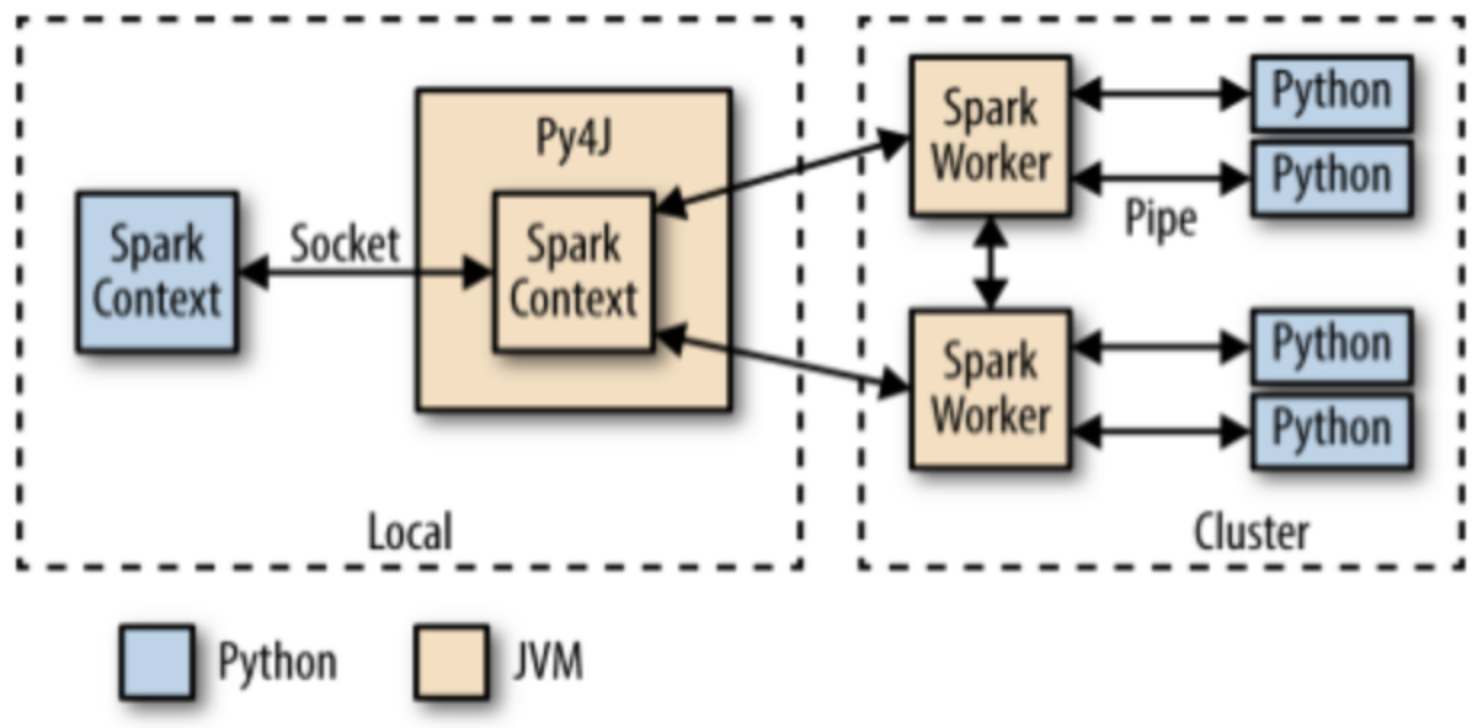

스파크 컨텍스트 객체는 내부에 자바(JAVA)로 동작하는 Py4J의 스파크 컨텍스트와 연결된다.

이 덕분에 파이썬(Python)으로 코딩하면서 자바 위에서 동작하는 프로그램을 작성할 수 있다.

RDD를 만들 수 있다.

In [15]:
conf = SparkConf().setMaster("local").setAppName("uber-date-trips")
sc = SparkContext.getOrCreate(conf=conf) # 반드시 sc로 네이밍을 해줘야 하는 컨벤션이 있다.

setMaster("local"): 분산된 환경이 아닌 개발용 로컬 환경을 쓴다.

setAppName: 스파크 UI에서 확인 가능한 스파크 앱 이름이다.

**데이터 로딩 후 RDD 생성**

In [ ]:
lines = sc.textFile("fhvhv_tripdata_2020-03.csv")

**필요한 부분 추출**

In [ ]:
header = lines.first()
filtered_lines = lines.filter(lambda row:row != header)

# """def f(row):
#     return row != header
# lines.filter(f)"""

헤더를 제외하여 객체에 담는다.

In [ ]:
dates = filtered_lines.map(lambda x: x.split(",")[2].split(" ")[0])

map() 함수로 원하는 부분만 추출한다.

함수를 쪼개어보면 아래와 같다.

오리지널 데이터

HV0005,B02510,2020-03-01 00:03:40,2020-03-01 00:23:39,81,159,

x.split(",")

[HV0005,B02510,2020-03-01 00:03:40,2020-03-01 00:23:39,81,159,]

x.split(",")[2]

[2020-03-01 00:03:40]

x.split(",")[2].split(" ")

[2020-03-01,00:03:40]

x.split(",")[2].split(" ")[0]

2020-03-01

**카운트**

In [ ]:
result = dates.countByValue()
'''
(2020-03-01,3)
(2020-03-02,2)
(2020-03-03,1)
'''

**result는 더 이상 RDD가 아닌 파이썬 객체**

In [ ]:
# Spark코드가 아닌 일반적인 파이썬 코드
# CSV로 결과값 저장 후 시각화
pd.Series(result, name="trips").to_csv("trips-date.csv")

import matplotlib.pyplot as plt
%matplotlib inline  

trips = pd.read_csv("trips_date.csv")
trips.plot()